# Capstone project : Bicing dock availability prediction

### Authors: Anderson Castillo, Rohit Lachman, Pau Torrente

In this notebook we present the code used to do the last step of data preprocessing (all the merging of the data obtained from Barcelona OpenData has been done using tableau) and to train 2 different models to predict the availability of free docks in Barcelona's public bike sharing network. Finally, we have also created a few heatmaps that display the usage of the network in the city, and possible placements for new stations.

# Warning
The following code, aswell as all the folder containing the data needed to run this notebook, have been built on top of Google Drive and Colab, due to the huge dataset sizes and the need for GPU's. We suggest copying the project's folder (https://drive.google.com/drive/folders/1ZIY2ZMhsCITuSFC1bnIDJrbZh-sS63HP?usp=drive_link) and making shure that it is saved in your drive as /content/drive/MyDrive/CapstoneProject

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# google drive mounting for running on colab --> All the code contains drive folders
# that might have to be adjusted, depending on the user

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# pip install required for the ml part of dask
! pip install dask_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 4.6 MB/s eta 0:00:00


# Data importing and initial cleaning

The initial data merging and reshaping has been done using tableau due to RAM limitations. In the following code cell the data is imported and cleaned with the following criteria:
- We will only consider location of the station, timestamp information, and previous % of occupation.
- We ignore 2020 data to not work with the data most affected by covid
- We use the all data from 2019 through 2022 as training data and the first two months of 2023 as validation data. March 2023 will be used as test data, checked in the kaggle competition
- We only consider data that corresponds to active station (marked with status = 1) and with an availability percentage between 0 and 1 (many register had higer % and we have consdiered them non-valid/corrupted data)

Apart from the data from the from BCNOpenData we have also gathered information about the weather using the meteo.cat api. The script used, that can be found in the weather folder on this repo alongside the csv file that it generates, gathers the weather data regarding temperature and precipitation in intervals of 30 minutes from the station located in Plaça Universitat (we chose this station due to its location in the center of the city, which we felt like would give a pretty good estimate of the overall weather in the city). The dataframe that this script generates is also imported.

In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from dask_ml.preprocessing import StandardScaler, MinMaxScaler
from dask_ml.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.display import Markdown
from xgboost import plot_importance
from matplotlib import pyplot
import json



station_dataframe = dd.read_csv('/content/drive/MyDrive/CapstoneProject/merged_data/data_bicing_joined_HX.csv', assume_missing=True, delimiter=';')

weather_dataframe = dd.read_csv('/content/drive/MyDrive/CapstoneProject/weather/weather.csv', assume_missing=True, delimiter=',')

####################################################################################################

station_dataframe = station_dataframe.loc[station_dataframe['status'] == 'IN_SERVICE']

##################################################################################################

train_df = station_dataframe.loc[(station_dataframe['year'] != 2020) & (station_dataframe['year'] != 2023)]

train_df = train_df[['station_id', 'lat', 'lon', 'year', 'month', 'day', 'hour', '% Docks Availlable',  '% Docks Available H-4','% Docks Available H-3', '% Docks Available H-2', '% Docks Available H-1']]
train_df = train_df.rename(columns={'% Docks Availlable': 'percentage'})
for i in range(1, 5):
    train_df = train_df.rename(columns={f'% Docks Available H-{i}': f'ctx-{i}'})

# Print the head of the updated DataFrame
train_df = train_df[['station_id', 'lat', 'lon', 'year', 'month', 'day', 'hour', 'ctx-4', 'ctx-3', 'ctx-2',	'ctx-1', 'percentage']]

train_df = train_df.reset_index()

##################################################################################################

validation_df = station_dataframe.loc[(station_dataframe['year'] == 2023)]

validation_df = validation_df[['station_id', 'lat', 'lon', 'year', 'month', 'day', 'hour', '% Docks Availlable',  '% Docks Available H-4','% Docks Available H-3', '% Docks Available H-2', '% Docks Available H-1']]
validation_df = validation_df.rename(columns={'% Docks Availlable': 'percentage'})
for i in range(1, 5):
    validation_df = validation_df.rename(columns={f'% Docks Available H-{i}': f'ctx-{i}'})

# Print the head of the updated DataFrame
validation_df = validation_df[['station_id', 'lat', 'lon', 'year', 'month', 'day', 'hour', 'ctx-4', 'ctx-3', 'ctx-2',	'ctx-1', 'percentage']]

validation_df = validation_df.reset_index()


In [ ]:
# We have found in previous test that our data contains many registers where the
# occupation percentage is over 1. Let's see how many do we have in our 5 percentage columns

count_ctx_4 = train_df['ctx-4'].apply(lambda x: x > 1, meta=('ctx-4', 'boolean')).sum().compute()
count_ctx_3 = train_df['ctx-3'].apply(lambda x: x > 1, meta=('ctx-3', 'boolean')).sum().compute()
count_ctx_2 = train_df['ctx-2'].apply(lambda x: x > 1, meta=('ctx-2', 'boolean')).sum().compute()
count_ctx_1 = train_df['ctx-1'].apply(lambda x: x > 1, meta=('ctx-1', 'boolean')).sum().compute()
count_percentage = train_df['percentage'].apply(lambda x: x > 1, meta=('percentage', 'boolean')).sum().compute()

print("Count of values > 1:")
print("ctx-4: ", count_ctx_4)
print("ctx-3: ", count_ctx_3)
print("ctx-2: ", count_ctx_2)
print("ctx-1: ", count_ctx_1)
print("percentage: ", count_percentage)

Count of values > 1:
ctx-4:  60482
ctx-3:  60509
ctx-2:  60539
ctx-1:  60558
percentage:  60615


In [ ]:
# There are many X%>100% --> We remove all of them, also from the validation set

train_df = train_df[(train_df['ctx-4'] <= 1) & (train_df['ctx-3'] <= 1) & (train_df['ctx-2'] <= 1) & (train_df['ctx-1'] <= 1) & (train_df['percentage'] <= 1)]
validation_df = validation_df[(validation_df['ctx-4'] <= 1) & (validation_df['ctx-3'] <= 1) & (validation_df['ctx-2'] <= 1) & (validation_df['ctx-1'] <= 1) & (validation_df['percentage'] <= 1)]

We also import the submission dataframe from the competition's kaggle webpage. To be able to work with the location of the stations, and since this dataframe initially does not contain information about the latitude and the longitude of the stations, we also import the information dataframe from february (we will not use any data from march 2023) to merge the latitude and longitude onto the submission dataframe using the station id

In [ ]:
# We now import the submission dataframe to be predicted

data_2_predict = dd.read_csv('/content/drive/MyDrive/CapstoneProject/merged_data/metadata_sample_submission.csv', delimiter=',')

data_2_predict.head()

In [ ]:
# Import febrary 2023 station info to get the lat and lon of the stations --> March 2023 info could be used as well
# but to not even touch the data that we aim to predict and submit, we will take the previous month


february2023_info = pd.read_csv('/content/drive/MyDrive/CapstoneProject/data_bicing/2023_02_Febrer_BicingNou_INFORMACIO.csv', delimiter=',')

# From the info dataset, we retrieve the unique the location of each unique station
final_loc = february2023_info.drop_duplicates(subset=['station_id'], keep='last')[['station_id', 'lat', 'lon']]

In [ ]:
final_loc.head() # this dataframe containing the lat and lon for each station will be used to perform the merge

,station_id,lat,lon
1048556,500,41.411957,2.144752
3821777,520,41.386220,9.150292
3853425,494,41.389697,2.165220
4044289,21,41.410844,2.174057
4049296,515,41.435207,2.194800


We finally do some final processing on the weather dataframe. The api returns data in intervals of 30 minutes, and since we will work in hourly intervals, we sum precipitation over two registers and average the temperature. We also modify the time format to be able to merge with the stations dataframe.

In [ ]:
def weather_prep(weather_df:dd) -> dd:

    # weather dataframe preparator to leave it in the desired format to merge with the station dataframe
    # We convert the half hourly data to hourly data by averaging temperature and summing precipitation
    # We also add a column with the datetime in order to merge the dataframes

    weather = weather_df.copy()

    weather = weather.groupby(weather.index//2).mean()

    weather['mm_precip'] = weather['mm_precip']*2
    weather['timestamp'] = (weather['timestamp']-900).astype(int)
    weather['datetime'] = weather['timestamp'].map(lambda x: pd.to_datetime(x, unit='s'))


    weather['timestamp'] = weather['timestamp'].astype(int)

    weather['datetime'] = weather['timestamp'].map(lambda x: pd.to_datetime(x, unit='s'))

    weather = weather.drop_duplicates(subset=['timestamp'])

    return weather


weather_prepped = weather_prep(weather_dataframe)

weather_prepped.head()

,timestamp,mm_precip,temperature,datetime
0,1546297200,0.0,9.00,2018-12-31 23:00:00
1,1546300800,0.0,9.10,2019-01-01 00:00:00
2,1546304400,0.0,8.45,2019-01-01 01:00:00
3,1546308000,0.0,7.55,2019-01-01 02:00:00
4,1546311600,0.0,7.50,2019-01-01 03:00:00


# Processing pipelines

Apart from the preprocessing done using tableu to create the initial dataframe, everything else will be done using sklearn pipelines. We will have 3 different pipelines to prepare all the data, that work in the following way:
- train_preparator: used on training and one set of validation data. It adds the weather information, selects only register with hours 0, 4, 9, 14, 19, 23 to not have overlap between data rows and remove any possibilty of the model seeing % that will later predict and lastly it codifies the time data using trigonometric functions to account for the periodicity (years 2019 to 2023 are normalized to 0-1). In this pieline we also mark the data depending on if they correspond to a weekend day (friday, saturday and sunday) and lastly we remove the station id.
- validation preparator: same procedure as train_preparator but not filtering hours, to create a dataframe as similar as possible to the submission.
- submission preparator: similar procedure to validation_preparator but also adding the location of the stations into the submission dataframe.

After we apply these pipelines, all the data is passed through another pipeline that fills nan's and scales all the data regarding weather and location (the rest already belong to intervals between 0 and 1 or between .1 and +1), that is fitted only with the training dataset.

In [ ]:

def weather_merge(weather_df: dd, station_data: dd) -> dd:
    weather = weather_df.copy().compute()
    stations = station_data.copy().compute()

    if 'year' not in stations.columns:  # the submission df does not contain year, and we need will use that to predict
        stations['year'] = 2023

    stations[['year', 'month', 'day', 'hour']] = stations[['year', 'month', 'day', 'hour']].astype(int)

    stations['datetime'] = pd.to_datetime(stations['year'].astype(str) + '-' +
                                        stations['month'].astype(str) + '-' +
                                        stations['day'].astype(str) + ' ' +
                                        stations['hour'].astype(str) + ':00:00')

    weather['datetime'] = pd.to_datetime(weather['datetime'])

    # Sorting dataframes by datetime for the asof merge
    weather = weather.sort_values('datetime')
    stations = stations.sort_values('datetime')

    # Merge for the current datetime
    stations = pd.merge_asof(stations, weather[['datetime', 'temperature', 'mm_precip']], left_on='datetime', right_on='datetime', direction='backward')

    # Iterate to merge for the preceding datetimes
    for i in range(1, 5):
        df_weather_shifted = weather.copy()
        df_weather_shifted['datetime'] += pd.Timedelta(hours=i) # shift weather data i hours forward
        stations = pd.merge_asof(stations, df_weather_shifted[['datetime', 'temperature', 'mm_precip']], left_on='datetime', right_on='datetime', direction='backward', suffixes=('', f'-{i}'))

    return dd.from_pandas(stations, npartitions=5)  # Convert back to Dask DataFrame


####################################################################################################


class weather_merge_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, weather_df:dd, merging_function:callable=weather_merge):
        self.weather_df = weather_df
        self.func = merging_function

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.func(self.weather_df, X)

####################################################################################################
####################################################################################################


def extra_time_info(df:dd) -> dd:

    def is_weekend(day_of_week):
        return 1 if day_of_week >= 5 else 0

    # Create a column to distinguish id ii's a weekend or not
    df['is_weekend'] = df['datetime'].dt.dayofweek.map(is_weekend, meta=('is_weekend', 'int64'))

    # Since we will only be working with 5 hours in the training dataset, we add 5 binary columns to indicate in which part of the day we are
    # to sort of solve the problem of the missing hours for training

    df['timeframe1'] = df['datetime'].dt.hour.map(lambda x: 1 if x <= 4 else 0, meta=('timeframe1', 'int64'))
    df['timeframe2'] = df['datetime'].dt.hour.map(lambda x: 1 if x >= 5 and x <=9 else 0, meta=('timeframe1', 'int64'))
    df['timeframe3'] = df['datetime'].dt.hour.map(lambda x: 1 if x >= 10 and x <=14 else 0, meta=('timeframe1', 'int64'))
    df['timeframe4'] = df['datetime'].dt.hour.map(lambda x: 1 if x >= 15 and x <=19 else 0, meta=('timeframe1', 'int64'))
    df['timeframe5'] = df['datetime'].dt.hour.map(lambda x: 1 if x >= 20 else 0, meta=('timeframe1', 'int64'))

    df = df.drop(['datetime'], axis = 1)

    return df

####################################################################################################


def station_loc(id_lat_lon:dd, df:dd) -> dd: #this should be applied for the 2023 march dataset to predict from station_id-location paris from february 2023

    # station location adder from the february 2023 dataset to substitute station_id for locations

    assert all(item in list(id_lat_lon.columns) for item in ['station_id', 'lat', 'lon']), 'id_lat_lon must contain station_id, lat and lon columns'
    id_locator = id_lat_lon.copy()
    data = df.copy()
    id_locator = id_locator.drop_duplicates(subset=['station_id'])

    data = data.merge(id_locator[['station_id', 'lat', 'lon']], on='station_id', how='left')

    return data

class station_loc_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, id_lat_lon:dd, merging_function:callable=station_loc):
        self.id_lat_lon = id_lat_lon
        self.func = merging_function

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.func(self.id_lat_lon, X)

####################################################################################################



def hour_selector(df:dd, hour_list:list) -> dd:

    # Hour selector function to select only the hours we want to train on
    # in our case we will only train on 5 hours of the day, but a more complicated function
    # that would cover all hours could also be constructed

    data = df.copy()
    data = data.loc[data['hour'].isin(hour_list)]
    return data

class hour_selector_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, hour_list:list):
        self.hour_list = hour_list

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return hour_selector(X, self.hour_list)

####################################################################################################


def time_norm(df:dd, columns:list) -> dd:
    # Time normalizer function to normalize the time columns to a 0-1 scale with periodicity
    # This is done by applying a sin and cos transformation to the columns

    data = df.copy()
    for col in columns:
        data['cos_'+col] = np.cos(2*np.pi*data[col]/data[col].max())
        data['sin_'+col] = np.sin(2*np.pi*data[col]/data[col].max())
        data = data.drop([col], axis=1)

    data['year_normed'] = (data['year']-2019)/4
    data = data.drop(['year'], axis = 1)

    return data

class time_norm_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list, norm_function: callable=time_norm):
        self.columns = columns
        self.func = norm_function

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.func(X, self.columns)

####################################################################################################

class station_id_dropper(BaseEstimator, TransformerMixin):

    # Station id dropper function to drop the station_id column from the dataset at the end of the pipeline
    # prediction will be done on the location of the stations, not on the id

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(['station_id'], axis=1)




In [ ]:
# Creation of the 3 pipelines:

train_preparator = Pipeline([
    ('weather_merge', weather_merge_transformer(weather_df=weather_prepped)),
    ('extra_time_info', FunctionTransformer(func=extra_time_info)),
    ('hour_selector', hour_selector_transformer(hour_list=[4, 9, 14, 19, 23])), # This obviously restricts the training set, but it prevents
                                                                                # the model from seeing data labels before predicting them afterwards
                                                                                # It also prevents running out of RAM. A better approach would need to sample all
                                                                                # all hours, but it is quite more complicated than this

    ('time_normalization', time_norm_transformer(columns=['month', 'day', 'hour'])),
    ('station_id_dropper', station_id_dropper())
])

val_preparator = Pipeline([
    ('weather_merge', weather_merge_transformer(weather_df=weather_prepped)),
    ('extra_time_info', FunctionTransformer(func=extra_time_info)),
    ('hour_selector', hour_selector_transformer(hour_list=[i for i in range(24)])), # For the validation part, we will leave one dataset with all the hours and another one
                                                                                    # with just the four that appear in the training set to evaluate how this decision affects results
    ('time_normalization', time_norm_transformer(columns=['month', 'day', 'hour'])),
    ('station_id_dropper', station_id_dropper())
])

submission_preparator = Pipeline([
    ('weather_merge', weather_merge_transformer(weather_df=weather_prepped)),
    ('extra_time_info', FunctionTransformer(func=extra_time_info)),
    ('hour_selector', hour_selector_transformer(hour_list=[i for i in range(24)])),
    ('time_normalization', time_norm_transformer(columns=['month', 'day', 'hour'])),
    ('station_loc', station_loc_transformer(id_lat_lon=final_loc)),
    ('station_id_dropper', station_id_dropper())
])



total_columns = ['index','lat', 'lon', 'ctx-4', 'ctx-3', 'ctx-2', 'ctx-1',
       'temperature', 'mm_precip', 'temperature-1', 'mm_precip-1',
       'temperature-2', 'mm_precip-2', 'temperature-3', 'mm_precip-3',
       'temperature-4', 'mm_precip-4', 'is_weekend', 'timeframe1',
       'timeframe2', 'timeframe3', 'timeframe4', 'timeframe5', 'cos_month',
       'sin_month', 'cos_day', 'sin_day', 'cos_hour', 'sin_hour',
       'year_normed']


to_fill = ['index', 'ctx-4', 'ctx-3', 'ctx-2', 'ctx-1', 'is_weekend', 'timeframe1',
                   'timeframe2', 'timeframe3', 'timeframe4', 'timeframe5', 'cos_month',
                   'sin_month', 'cos_day', 'sin_day', 'cos_hour', 'sin_hour',
                   'year_normed']


to_fill_and_scale = ['lat', 'lon', 'temperature', 'mm_precip', 'temperature-1', 'mm_precip-1',
       'temperature-2', 'mm_precip-2', 'temperature-3', 'mm_precip-3',
       'temperature-4', 'mm_precip-4']


filler = Pipeline([
    ('nan_filler', SimpleImputer(missing_values = np.nan, strategy='median'))
])

filler_scaler= Pipeline([
    ('nan_filler', SimpleImputer(missing_values = np.nan, strategy='median')),
    ('min_max', MinMaxScaler(feature_range = (-1,1)))
])

scaling_pipeline = ColumnTransformer([
    ('fill', filler, to_fill),
    ('fill_scale', filler_scaler, to_fill_and_scale)
])


# Prepare all data and save it accordingly
--> The following code takes a while to run and the results of it have been saved in the prepped_data folder, so there is no need to run this code again. We will just load it from our folder to work with the models


In [ ]:
# Complete the data for training/validation

train_prepared = train_preparator.transform(train_df)

train_prepared.compute().to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/full_training.csv', index=False)

In [ ]:
validation_prepared = train_preparator.transform(validation_df)  # the set with only the 5 hours can be transformed with the same transformer as the train set

validation_prepared.compute().to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/full_validation.csv', index=False)

validation_prepared24h = val_preparator.transform(validation_df)

validation_prepared24h.compute().to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/full_validation24h.csv', index=False)

In [ ]:
# Apply the scaling pipelines to both sets of data and them into csv files

y_train = train_prepared['percentage'].values.compute()
ydf_train = pd.DataFrame({'percentage': y_train})
ydf_train.to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_train.csv', index=False)

X_train = pd.DataFrame(scaling_pipeline.fit_transform(train_prepared), columns= to_fill + to_fill_and_scale)
X_train.to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_train.csv', index=False)

#########################################################################################################

y_val = validation_prepared['percentage'].values.compute()
ydf_val = pd.DataFrame({'percentage': y_val})
ydf_val.to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_val.csv', index=False)

X_val = pd.DataFrame(scaling_pipeline.transform(validation_prepared), columns= to_fill + to_fill_and_scale)
X_val.to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_val.csv', index=False)

#########################################################################################################

y_val24h = validation_prepared['percentage'].values.compute()
ydf_val24h = pd.DataFrame({'percentage': y_val24h})
ydf_val24h.to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_val24.csv', index=False)

X_val24h = pd.DataFrame(scaling_pipeline.transform(validation_prepared24h), columns= to_fill + to_fill_and_scale)
X_val24h.to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_val24.csv', index=False)

In [ ]:
# Complete the data for submission and save it to a csv file

data_2_predict_prepared = submission_preparator.fit_transform(data_2_predict)
data_2_predict_prepared = data_2_predict_prepared.sort_values(by = 'index')
data_2_predict_prepared.compute().to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/full_submission.csv', index=False)


In [ ]:
# Apply the pipeline to the submission data and save it to a csv file

X_submission = pd.DataFrame(scaling_pipeline.transform(data_2_predict_prepared), columns= to_fill + to_fill_and_scale)
X_submission.to_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_submission.csv', index=False)

# Load data that has been processed and saved


In [ ]:
X_submission = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_submission.csv')
X_train = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_train.csv', delimiter = ',').drop('index', axis = 1)
y_train = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_train.csv', delimiter = ',')

X_val = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_val.csv', delimiter = ',').drop('index', axis = 1)
y_val = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_val.csv', delimiter = ',')

X_val24 = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_val24.csv', delimiter = ',').drop('index', axis = 1)
y_val24 = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_val24.csv', delimiter = ',')



In [ ]:
X_train.head()

,ctx-4,ctx-3,ctx-2,ctx-1,is_weekend,timeframe1,timeframe2,timeframe3,timeframe4,timeframe5,...,temperature,mm_precip,temperature-1,mm_precip-1,temperature-2,mm_precip-2,temperature-3,mm_precip-3,temperature-4,mm_precip-4
0,0.859259,0.925926,0.882716,0.885802,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.397143,-1.0,-0.348378,-1.0,-0.366762,-1.0,-0.38307,-1.0,-0.359773,-1.0
1,0.987500,1.000000,0.673611,0.708333,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.397143,-1.0,-0.348378,-1.0,-0.366762,-1.0,-0.38307,-1.0,-0.359773,-1.0
2,0.703704,0.589506,0.521605,0.864198,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.397143,-1.0,-0.348378,-1.0,-0.366762,-1.0,-0.38307,-1.0,-0.359773,-1.0
3,0.793750,0.846354,0.963542,0.997396,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.397143,-1.0,-0.348378,-1.0,-0.366762,-1.0,-0.38307,-1.0,-0.359773,-1.0
4,0.054545,0.030303,0.106061,0.060606,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.397143,-1.0,-0.348378,-1.0,-0.366762,-1.0,-0.38307,-1.0,-0.359773,-1.0


In [ ]:
X_val.head()

,ctx-4,ctx-3,ctx-2,ctx-1,is_weekend,timeframe1,timeframe2,timeframe3,timeframe4,timeframe5,...,temperature,mm_precip,temperature-1,mm_precip-1,temperature-2,mm_precip-2,temperature-3,mm_precip-3,temperature-4,mm_precip-4
0,0.738667,0.633333,0.450000,0.310000,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.48,-1.0,-0.444288,-1.0,-0.515759,-1.0,-0.497848,-1.0,-0.458924,-1.0
1,0.562963,0.478395,0.567901,0.669753,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.48,-1.0,-0.444288,-1.0,-0.515759,-1.0,-0.497848,-1.0,-0.458924,-1.0
2,0.066667,0.007937,0.011905,0.376984,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.48,-1.0,-0.444288,-1.0,-0.515759,-1.0,-0.497848,-1.0,-0.458924,-1.0
3,0.113131,0.070707,0.045455,0.030303,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.48,-1.0,-0.444288,-1.0,-0.515759,-1.0,-0.497848,-1.0,-0.458924,-1.0
4,0.820513,0.820513,0.820513,0.820513,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.48,-1.0,-0.444288,-1.0,-0.515759,-1.0,-0.497848,-1.0,-0.458924,-1.0


In [ ]:
X_val24.head()

,ctx-4,ctx-3,ctx-2,ctx-1,is_weekend,timeframe1,timeframe2,timeframe3,timeframe4,timeframe5,...,temperature,mm_precip,temperature-1,mm_precip-1,temperature-2,mm_precip-2,temperature-3,mm_precip-3,temperature-4,mm_precip-4
0,0.672414,0.718391,0.729885,0.785146,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.457143,-1.0,-0.407616,-1.0,-0.383954,-1.0,-0.377331,-1.0,-0.359773,-1.0
1,0.813725,0.681373,0.686275,0.675716,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.457143,-1.0,-0.407616,-1.0,-0.383954,-1.0,-0.377331,-1.0,-0.359773,-1.0
2,0.493827,0.626543,0.725309,0.760684,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.457143,-1.0,-0.407616,-1.0,-0.383954,-1.0,-0.377331,-1.0,-0.359773,-1.0
3,0.632812,0.601562,0.593750,0.600962,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.457143,-1.0,-0.407616,-1.0,-0.383954,-1.0,-0.377331,-1.0,-0.359773,-1.0
4,0.829545,0.833333,0.840909,0.840909,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.457143,-1.0,-0.407616,-1.0,-0.383954,-1.0,-0.377331,-1.0,-0.359773,-1.0


In [ ]:
X_submission.head()


,index,ctx-4,ctx-3,ctx-2,ctx-1,is_weekend,timeframe1,timeframe2,timeframe3,timeframe4,...,temperature,mm_precip,temperature-1,mm_precip-1,temperature-2,mm_precip-2,temperature-3,mm_precip-3,temperature-4,mm_precip-4
0,0.0,0.753086,0.780864,0.799383,0.824074,0.0,0.0,1.0,0.0,0.0,...,-2.057143e-01,-1.0,-0.275035,-1.0,-0.438395,-1.0,-0.618364,-1.0,-0.620397,-1.0
1,1.0,0.463768,0.536232,0.532609,0.601449,0.0,0.0,0.0,1.0,0.0,...,-2.220446e-16,-1.0,0.018336,-1.0,0.011461,-1.0,-0.032999,-1.0,-0.090652,-1.0
2,2.0,0.787037,0.709877,0.611111,0.601852,0.0,1.0,0.0,0.0,0.0,...,-3.142857e-01,-1.0,-0.325811,-1.0,-0.318052,-1.0,-0.302726,-1.0,-0.294618,-1.0
3,3.0,0.753472,0.809028,0.819444,0.736111,0.0,0.0,0.0,0.0,1.0,...,-1.542857e-01,-1.0,-0.139633,-1.0,-0.080229,-1.0,-0.012912,-1.0,0.016997,-1.0
4,4.0,0.861111,0.802469,0.814815,0.827160,1.0,0.0,0.0,0.0,0.0,...,-5.771429e-01,-1.0,-0.517630,-1.0,-0.518625,-1.0,-0.474892,-1.0,-0.393768,-1.0


In [ ]:
# We confirm that we are retaining the same number of rows after proecessing --> Earlier versions of the code gave problems regarding to this

X_submission.shape

(54999, 30)

# Model selection and training

For this project we will use 2 different models. The first one is an xgboost regressor, that has been chosen following other similar projects to this one and that has outperformed with less training times other similar ensemble models.
Then, a neural network containing LSTM layers is used to capture the temporal features and their ordering.



## XGBregressor

We will first use a data subset to perform a grid search on the parameter space to find the ones that fit the best our xgboost model.

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import json
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

gs_subset = X_train[X_train['year_normed'] == 0.75].sample(frac = 0.005, random_state = 5) # to restrict ourselves to more relevant data, we focus on 2022
                                                                                           # and we use a small sample as the process takes a lot of time
                                                                                           # We suspect that this is not giving optimal parameters (more on
                                                                                           # this later) due to the small sample size

y_subset = y_train.loc[gs_subset.index]


space = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],
    'reg_alpha': [0, 0.1, 1.0],
    'n_estimators': [30, 50, 100, 200]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state = 40)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=space, scoring='mean_squared_error', cv=2, verbose=2)

grid_search.fit(gs_subset, y_subset)

Fitting 2 folds for each of 972 candidates, totalling 1944 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=30, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=30, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=30, reg_alpha=0, reg_lambda=0.1, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=30, reg_alpha=0, reg_lambda=0.1, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=30, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=30, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=30, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=30, reg_alpha=0, reg_lambda=1.0, su

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=40, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [30, 50, 100, 200],
                         'reg_alpha': [0, 0.1, 1.0],
                         'reg_lambda': [0.1, 1.0, 10.0],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0.1,
 'reg_lambda': 10.0,
 'subsample': 0.8}

In [ ]:
import json

# Once we have found the best set of parameters, we save them

parameter = open('/content/drive/MyDrive/CapstoneProject/models/xgboost/best_params.json', 'w+')
parameter.write(json.dumps(grid_search.best_params_))
parameter.close()


In [ ]:
# And now that we have the best parameters for our subset of data we train the model.
# We also use the validation dataset to monitor the performance of the model
# during training to look for overfitting curves

xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, gamma=0.1, n_jobs=-1, random_state=123, eval_metric = 'rmse', early_stopping_rounds = 30)

with open('/content/drive/MyDrive/CapstoneProject/models/xgboost/best_params.json', 'r') as f:
  best_params = json.load(f)

xgb_model.set_params(**best_params)

evalset = [(X_train, y_train), (X_val, y_val), (X_val24, y_val24)]

xgb_model.fit(X_train, y_train, eval_set = evalset)

y_pred = xgb_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_true = y_val, y_pred = y_pred))

print('rmse:', rmse)

[0]	validation_0-rmse:0.28248	validation_1-rmse:0.25879	validation_2-rmse:0.25481
[1]	validation_0-rmse:0.25987	validation_1-rmse:0.23870	validation_2-rmse:0.23439
[2]	validation_0-rmse:0.23998	validation_1-rmse:0.22111	validation_2-rmse:0.21649
[3]	validation_0-rmse:0.22248	validation_1-rmse:0.20577	validation_2-rmse:0.20084
[4]	validation_0-rmse:0.20718	validation_1-rmse:0.19242	validation_2-rmse:0.18721
[5]	validation_0-rmse:0.19385	validation_1-rmse:0.18094	validation_2-rmse:0.17546
[6]	validation_0-rmse:0.18230	validation_1-rmse:0.17108	validation_2-rmse:0.16535
[7]	validation_0-rmse:0.17234	validation_1-rmse:0.16264	validation_2-rmse:0.15677
[8]	validation_0-rmse:0.16370	validation_1-rmse:0.15539	validation_2-rmse:0.14938
[9]	validation_0-rmse:0.15946	validation_1-rmse:0.15223	validation_2-rmse:0.14585
[10]	validation_0-rmse:0.15285	validation_1-rmse:0.14676	validation_2-rmse:0.14033
[11]	validation_0-rmse:0.14712	validation_1-rmse:0.14202	validation_2-rmse:0.13558
[12]	validatio

Once we have trained the model, we are interested in knowing how the loss evolved during training, aswell as what variables were the most relevant to predict the percentage of available docks

[]

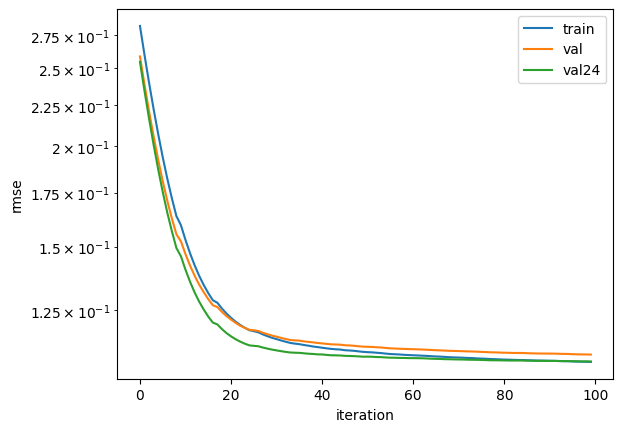

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

results = xgb_model.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='val')

pyplot.plot(results['validation_2']['rmse'], label='val24')
pyplot.xlabel('iteration')
pyplot.ylabel('rmse')
pyplot.yscale('log')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig('/content/drive/MyDrive/CapstoneProject/plots and figures/xgb_loss.png')
pyplot.plot()

[]

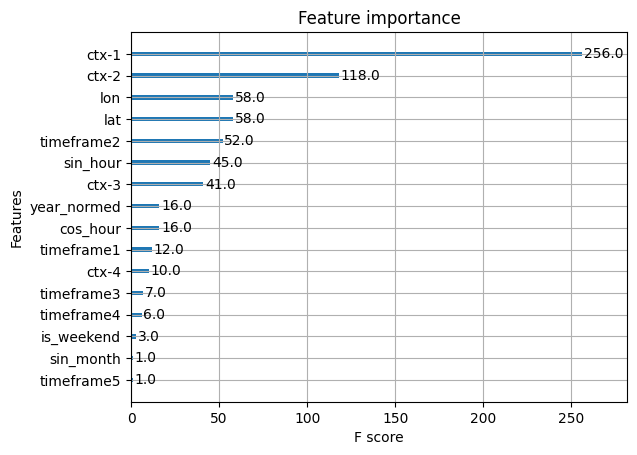

In [ ]:
plot_importance(xgb_model)
pyplot.savefig('/content/drive/MyDrive/CapstoneProject/plots and figures/xgb_features.png')
pyplot.plot()

The feature important plot is really interesting. From it we can conclude that:
- A expected, the previous hours percentage gives a lot of info about how many docks will be available in the following hours.
- The location of the station are the next most relevant features. The usage of the service is not homogeneus across the city and this impacts te availability of docks
- timeframe2, corresponding to peak hours in the morning has quite a bit of weight. The stations network probably has the most activity in these hours
- the hour also affects quite a bit the final %, as expected --> Since we are only training with
- The weather does not even appear in the graph. We expected way more weight from those variables, especially rain. We guess that since Barcelon is not a very rainy city, the model does not see many registers with rain and so it end up ignoring completely the variable

In [ ]:
xgb_model.save_model('/content/drive/MyDrive/CapstoneProject/models/xgboost/xgb.json')

In [ ]:
y_submission = xgb_model.predict(X_submission.drop('index', axis = 1))
prediction = pd.DataFrame({'percentage_docks_available':y_submission.flatten()})
prediction = prediction.reset_index()
prediction.to_csv('/content/drive/MyDrive/CapstoneProject/models/xgboost/xgb_prediction.csv', index = False)

### Second XGBoost model
In an earlier version of the code, we started with different parameters, using 1000 estimators and a max depth of 6, and ended up getting better results. Let's try to replicate that behaviour with a more complex model that uses more estimators, aswell as higher max_depth, even though the grid search gave us different results, to see if we can get better performance out of the model.

In [ ]:
# In this case the parameters are selected "through intuition" (or in spanish, a ojo)


xgb_model2 = XGBRegressor(objective='reg:squarederror',
                          n_estimators=2000,
                          max_depth=10,
                          learning_rate=0.1,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          gamma=0.1,
                          reg_alpha=0.1,
                          reg_lambda=10.0,
                          n_jobs=-1,
                          random_state=128,
                          early_stopping_rounds = 30)

evalset = [(X_train, y_train), (X_val, y_val), (X_val24, y_val24)]

xgb_model2.fit(X_train, y_train, eval_set = evalset)

y_pred = xgb_model2.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_true = y_val, y_pred = y_pred))

print('rmse:', rmse)

[0]	validation_0-rmse:0.27058	validation_1-rmse:0.24739	validation_2-rmse:0.24439
[1]	validation_0-rmse:0.24812	validation_1-rmse:0.22763	validation_2-rmse:0.22466
[2]	validation_0-rmse:0.22820	validation_1-rmse:0.21012	validation_2-rmse:0.20713
[3]	validation_0-rmse:0.21058	validation_1-rmse:0.19470	validation_2-rmse:0.19173
[4]	validation_0-rmse:0.19510	validation_1-rmse:0.18136	validation_2-rmse:0.17840
[5]	validation_0-rmse:0.18157	validation_1-rmse:0.16969	validation_2-rmse:0.16680
[6]	validation_0-rmse:0.16978	validation_1-rmse:0.15973	validation_2-rmse:0.15688
[7]	validation_0-rmse:0.16178	validation_1-rmse:0.15346	validation_2-rmse:0.15064
[8]	validation_0-rmse:0.15271	validation_1-rmse:0.14576	validation_2-rmse:0.14298
[9]	validation_0-rmse:0.14495	validation_1-rmse:0.13940	validation_2-rmse:0.13669
[10]	validation_0-rmse:0.13820	validation_1-rmse:0.13387	validation_2-rmse:0.13127
[11]	validation_0-rmse:0.13249	validation_1-rmse:0.12924	validation_2-rmse:0.12671
[12]	validatio

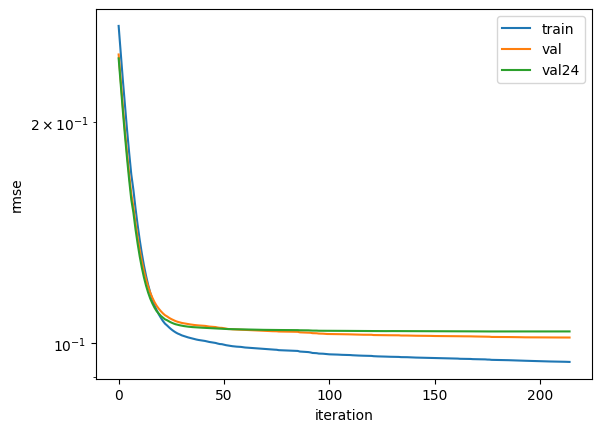

In [ ]:
results2 = xgb_model2.evals_result()
pyplot.plot(results2['validation_0']['rmse'], label='train')
pyplot.plot(results2['validation_1']['rmse'], label='val')

pyplot.plot(results2['validation_2']['rmse'], label='val24')
pyplot.xlabel('iteration')
pyplot.ylabel('rmse')
pyplot.yscale('log')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig('/content/drive/MyDrive/CapstoneProject/plots and figures/xgb_loss2.png')

pyplot.show()

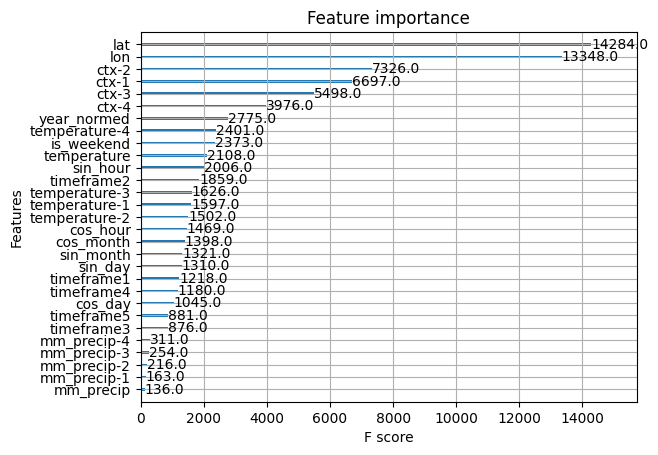

In [ ]:
plot_importance(xgb_model2)
pyplot.savefig('/content/drive/MyDrive/CapstoneProject/plots and figures/xgb2_features.png')
pyplot.show()

And in this new model, while it does get slightly better results, the higher complexity seems to lead to some overfitting. It is also notable that in this case, the weight of the location of the station has increased quite a lot, and now the model is considering the temperature as valuable information to proedict the % of free docks available

In [ ]:
xgb_model2.save_model('/content/drive/MyDrive/CapstoneProject/models/xgboost/xgb2.json')


In [ ]:

y_submission2 = xgb_model2.predict(X_submission.drop('index', axis = 1))
prediction2 = pd.DataFrame({'percentage_docks_available':y_submission2.flatten()})
prediction2 = prediction2.reset_index()
prediction2.to_csv('/content/drive/MyDrive/CapstoneProject/models/xgboost/xgb2_prediction.csv', index = False)

## LSTM
 Apart from our xgbregressor model, and since our data contains historical data, we have also tried to study the prediction problem as a time-series analysis by working with long short-term memory layers on a neural network to try and exploit the temporal ordering of the information. Since not all the variables are historical, we have built a time series with just the one that are historical context, and we have treated the rest with a fully connected network. By uing this approach our intention is to capture not only the static context of the data, but also the past that leads to each station's state.
 The data corresponding to the two categories is first split into two grups.
 The static data is left as it is and the temporal is reshaped into a tensor that contains a third dimension with the information about previous timesteps.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

X_submission = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_submission.csv')
X_train = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_train.csv', delimiter = ',').drop('index', axis = 1)
y_train = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_train.csv', delimiter = ',')

X_val = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_val.csv', delimiter = ',').drop('index', axis = 1)
y_val = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_val.csv', delimiter = ',')

X_val24 = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/X_val24.csv', delimiter = ',').drop('index', axis = 1)
y_val24 = pd.read_csv('/content/drive/MyDrive/CapstoneProject/prepped_data/y_val24.csv', delimiter = ',')

#################################################################################


static_columns = ['is_weekend', 'timeframe1',
       'timeframe2', 'timeframe3', 'timeframe4', 'timeframe5', 'cos_month',
       'sin_month', 'cos_day', 'sin_day', 'cos_hour', 'sin_hour',
       'year_normed', 'lat', 'lon', 'temperature', 'mm_precip']


X_train_static = X_train[static_columns].values

X_train_ts = np.stack((X_train[['temperature-1', 'mm_precip-1', 'ctx-1']].values,
                       X_train[['temperature-2', 'mm_precip-2', 'ctx-2']].values,
                       X_train[['temperature-3', 'mm_precip-3', 'ctx-3']].values,
                       X_train[['temperature-4', 'mm_precip-4', 'ctx-4']].values),
                       axis = 1)
train_target = y_train[['percentage']].values

#################################################################################

X_val_static = X_val[static_columns].values

X_val_ts = np.stack((X_val[['temperature-1', 'mm_precip-1', 'ctx-1']].values,
                     X_val[['temperature-2', 'mm_precip-2', 'ctx-2']].values,
                     X_val[['temperature-3', 'mm_precip-3', 'ctx-3']].values,
                     X_val[['temperature-4', 'mm_precip-4', 'ctx-4']].values),
                     axis = 1)
val_target = y_val[['percentage']].values

#################################################################################

X_val24_static = X_val24[static_columns].values

X_val24_ts = np.stack((X_val24[['temperature-1', 'mm_precip-1', 'ctx-1']].values,
                       X_val24[['temperature-2', 'mm_precip-2', 'ctx-2']].values,
                       X_val24[['temperature-3', 'mm_precip-3', 'ctx-3']].values,
                       X_val24[['temperature-4', 'mm_precip-4', 'ctx-4']].values),
                     axis = 1)
val24_target = y_val24[['percentage']].values

################################################################################


X_sub_static = X_submission[static_columns].values

X_sub_ts = np.stack((X_submission[['temperature-1', 'mm_precip-1', 'ctx-1']].values,
                     X_submission[['temperature-2', 'mm_precip-2', 'ctx-2']].values,
                     X_submission[['temperature-3', 'mm_precip-3', 'ctx-3']].values,
                     X_submission[['temperature-4', 'mm_precip-4', 'ctx-4']].values),
                     axis = 1)




### Network construction

To operate with the two groups of data, the nework starts off with 2 LSTM layers and a dense network that work in parallel and that process the temporal data and static data, respectively. After this, the outputs are concatenated and passed thorugh 3 final dense layers that lead to a single neuron with a sigmoid activation function that returns a value between 0 and 1.
We have also added droupout layers to prevent overfitting (we will see that that is a problem with this model)

In [ ]:
import tensorflow as tf
import keras
from keras.layers import LSTM, Dense, Input, concatenate, Dropout, Bidirectional
from keras.regularizers import l1, l2
from keras.utils import plot_model


# Construct eh neural network by separating it into two parts, one for the time series data and one for the static data
# The time series data is fed into an LSTM layer, the static data is fed into a dense layer

ts_input = tf.keras.Input(shape=(4, 3), name='ts_input')
static_input = tf.keras.Input(shape = (17,), name='static_input')

####################################################################################################

LSTM1 = LSTM(64, activation='tanh', return_sequences=True)(ts_input)
dropout_lstm = Dropout(0.1)(LSTM1)
LSTM2 = LSTM(64, activation = 'tanh', return_sequences = False)(dropout_lstm)
lstm_out = Dropout(0.1)(LSTM2)

####################################################################################################

static1 = Dense(32, activation='relu')(static_input)
dropout_static = Dropout(0.1)(static1)
static2 = Dense(64, activation = 'relu')(dropout_static)
dropout_static2 = Dropout(0.1)(static2)
static3 = Dense(48, activation = 'relu')(dropout_static2)
dropout_static3 = Dropout(0.1)(static3)
static4 = Dense(32, activation = 'relu')(dropout_static3)
static_out = Dropout(0.1)(static4)

####################################################################################################

merged_out = concatenate([lstm_out, static_out]) # join the outputs of the LSTM and dense layers and pass them into a final neuron

layer_out1 = Dense(32, activation = 'relu')(merged_out)
dropout_out1 = Dropout(0.1)(layer_out1)
layer_out2 = Dense(24, activation = 'relu')(dropout_out1)
dropout_out2 = Dropout(0.1)(layer_out2)
layer_out3 = Dense(24, activation = 'relu')(dropout_out2)
dropout_out3 = Dropout(0.1)(layer_out3)
out_result = Dense(1, activation='sigmoid')(dropout_out3)

model = tf.keras.Model(inputs=[ts_input, static_input], outputs=out_result)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 static_input (InputLayer)      [(None, 17)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           576         ['static_input[0][0]']           
                                                                                                  
 dropout_2 (Dropout)            (None, 32)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 64)           2112        ['dropout_2[0][0]']              
                                                                                              

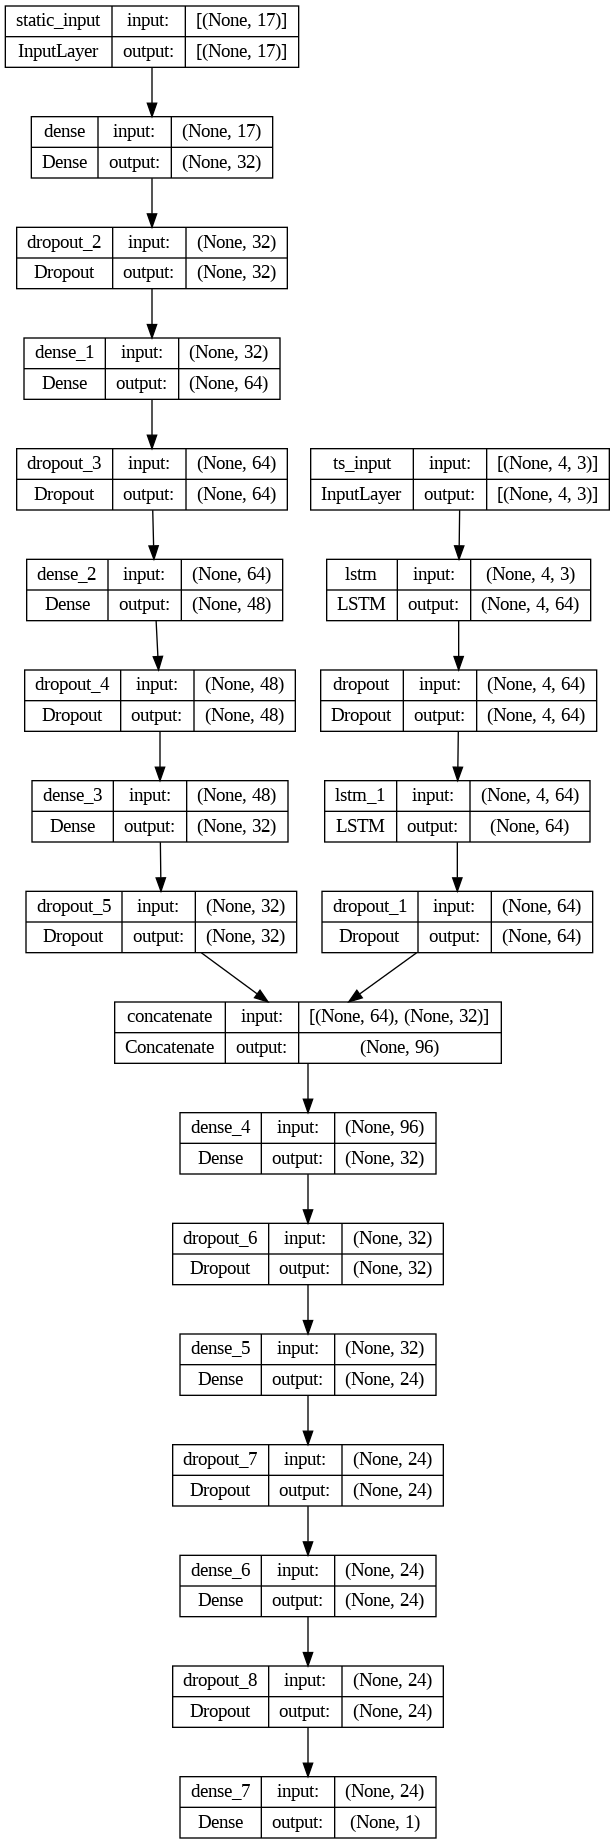

In [ ]:
plot_model(model, show_shapes = True, rankdir='TB')

In [ ]:
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', restore_best_weights = True)

# Now fit the model to the data, obtaining pretty good results, save the model to a file and then predict on the X_submission data

model.fit(x = [X_train_ts, X_train_static],
          y = train_target,
          batch_size = 64,
          epochs = 20,
          validation_data=([X_val24_ts, X_val24_static], val24_target), # keras only supports one set of validation data, so we use the one that
                                                                        # contains all 24h, taht resembles the most the submission set
          callbacks=[earlyStopping],
          shuffle=True)

Epoch 1/20
36547/36547 [==============================] - 399s 11ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 2/20
36547/36547 [==============================] - 394s 11ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 3/20
36547/36547 [==============================] - 364s 10ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 4/20
36547/36547 [==============================] - 349s 10ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/20
36547/36547 [==============================] - 356s 10ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 6/20
36547/36547 [==============================] - 372s 10ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 7/20
36547/36547 [==============================] - 427s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 8/20
36547/36547 [===

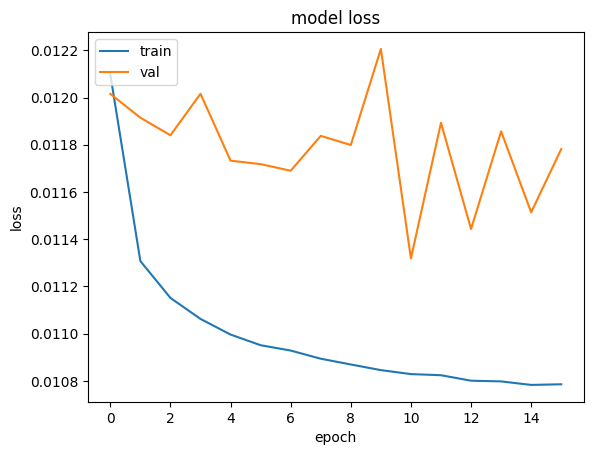

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

pyplot.plot(model.history.history['loss'])
pyplot.plot(model.history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'val'], loc='upper left')
pyplot.savefig('/content/drive/MyDrive/CapstoneProject/plots and figures/lstm_loss.png')
pyplot.show()

In [ ]:
import numpy as np
static_columns = ['is_weekend', 'timeframe1',
       'timeframe2', 'timeframe3', 'timeframe4', 'timeframe5', 'cos_month',
       'sin_month', 'cos_day', 'sin_day', 'cos_hour', 'sin_hour',
       'year_normed', 'lat', 'lon', 'temperature', 'mm_precip']

weights = model.get_weights()

# Calculate feature importance based on the weights
feature_importance = np.sort(np.mean(np.abs(weights[0]), axis=1))

# Print the importance of each feature
for i, importance in enumerate(feature_importance):
    print(f"{static_columns[i]}: {importance}")

is_weekend: 0.04162748157978058
timeframe1: 0.04198416694998741
timeframe2: 0.13254521787166595
timeframe3: 0.14563903212547302
timeframe4: 0.15736523270606995
timeframe5: 0.28035128116607666
cos_month: 0.2895676791667938
sin_month: 0.3056214451789856
cos_day: 0.3103480041027069
sin_day: 0.3388426899909973
cos_hour: 0.38680586218833923
sin_hour: 0.4838072955608368
year_normed: 0.5267024040222168
lat: 0.6065153479576111
lon: 0.69236820936203
temperature: 1.2320904731750488
mm_precip: 1.4689390659332275


Again, as with the more complex xgboost model, we see quite a bit of overfitting. On the other hand though, the model seems to prioritize weather quite a bit, which is something that we expected would be important but that the other two models didn't pay much attention to it.

In [ ]:
model.save('/content/drive/MyDrive/CapstoneProject/models/keras/lstm.h5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/CapstoneProject/models/keras/lstm.h5')

In [ ]:
y_pred = model.predict([X_sub_ts, X_sub_static])

1719/1719 [==============================] - 6s 3ms/step


In [ ]:
prediction = pd.DataFrame({'percentage_docks_available':y_pred.flatten()})
prediction = prediction.reset_index()
prediction.to_csv('/content/drive/MyDrive/CapstoneProject/models/keras/lstm_pred.csv', index = False)

We get reall similar results to that of the xgb model --> Further improvements should come from the hand of a better preproccesing probably, working with outliers and incorrect data in a more detailed way


# **Heatmap and buffer analysis**
### This section consists in two parts:


*   Creation of a dinamic heat map of dock availability that can be changed based on the month and year parameter. This will allow us to understand the pattern of bicycle usage across the city.  
*   Performance of a buffer analysis. Here we are going to search for areas that are near the bike lanes but do not have a nearby bike station to detect potential zones where new bike stations could be installed. The buffer has been set in 500 meters based on the size of the city and the number of stations.



## Heatmap ##

The following code is designed to generate and display the dinamic heatmap that represents the average availability of bike docks across the city, given a specific month and year.

In [ ]:
!pip install dash dash_core_components dash_html_components jupyter_dash
!pip install geopandas shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.6
    Uninstalling Werkzeug-2.3.6:
      Successfully uninstalled Werkzeug-2.3.6


In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd
import json
import numpy as np
import dask.dataframe as dd
import dash
from dash.dependencies import Input, Output
from dash import dcc as dcc
from dash import html as html
import base64
import os
from flask import Flask
from io import BytesIO
from jupyter_dash import JupyterDash
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point, Polygon
import geopy.distance
import math

In [ ]:
############################################################
# Create a joined dataframe of the historical data used for train and test that will be used for the heatmap analysis
df_info = pd.read_csv('/content/drive/MyDrive/CapstoneProject/df_info.csv')

In [ ]:
df_info.head()

,index,station_id,lat,lon,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage,average_percentage
0,0,444.0,41.371730,2.155405,2022.0,10.0,7.0,14.0,0.262346,0.050505,0.059829,0.010101,0.079772,0.092511
1,1,14.0,41.384844,2.185085,2022.0,2.0,16.0,11.0,0.669753,0.589226,0.512821,0.629630,0.629630,0.606212
2,2,23.0,41.392466,2.171740,2022.0,7.0,29.0,12.0,0.515432,0.484568,0.299383,0.290123,0.475309,0.412963
3,3,58.0,41.382680,2.167120,2022.0,3.0,17.0,23.0,0.457364,0.515856,0.588551,0.403101,0.401163,0.473207
4,4,480.0,41.433326,2.162926,2021.0,12.0,4.0,13.0,0.428571,0.450549,0.497024,0.500000,0.500000,0.475229


In [ ]:
df_info.shape

(11892390, 14)

In [ ]:
years = [i for i in range(2019, 2024)]
months = [i for i in range(1, 13)]

First we are going to calculate the average percentage of bike availability at each station using the historical data. then we will generate a heatmap based on this data, with coordinates of each station and a color intensity indicating the level of bike availability. This heatmap is overlaid onto the city map created using Folium, providing a clear visualization of bike availability in different areas of the city.

The resulting map is saved as an HTML file in a temporary location and then the interface powered by Dash includes dropdown menus for selecting the month and year of interest. The map updates dynamically based on these selections, providing a tool for exploring dock availability across different times.

In [ ]:
# Dash definition
app = JupyterDash(__name__)

# Function to generate the heatmap
def generate_heatmap(year, month):
    selected_info = df_info[(df_info['year'] == float(year)) & (df_info['month'] == float(month))]
    print("Selected info:")
    print(selected_info.head())

    selected_info['average_percentage'] = selected_info[['percentage', 'ctx-4', 'ctx-3', 'ctx-2', 'ctx-1']].mean(axis=1)
    average_availability = selected_info.groupby('station_id').mean().reset_index()
    print(average_availability.head())# average percentage of bike availability at each station

    # Create data for the heatmap (latitude, longitude, availability)
    heatmap_data = [(row['lat'], row['lon'], 1 - row['average_percentage']) for idx, row in average_availability.iterrows()]
    print(heatmap_data[:5])

    # Create a folium map centered around the city
    folium_map = folium.Map(location=[41.3870154, 2.1700471], zoom_start=13)


# Load the bike lane data from a GeoJSON file and add it to the map
    with open('/content/drive/MyDrive/CapstoneProject/maps/CARRIL_BICI.geojson') as f:
        bikelane_data = json.load(f)
    folium.GeoJson(bikelane_data).add_to(folium_map)

    HeatMap(heatmap_data).add_to(folium_map)

    # Map saved as html
    folium_map.save('/tmp/temp_map.html')

    # Copy in Google drive
    !cp /tmp/temp_map.html /content/drive/MyDrive/CapstoneProject/maps/

# Initial map for the first year and month
generate_heatmap(years[0], months[0])

# Dash Layout and dropdowns
app.layout = html.Div([
    html.H1("Disponibilidad de estaciones de Bicing"),
    html.H2(id='map-title', children="Disponibilidad: Mes/Año"),
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': str(year), 'value': year} for year in years],
        value=years[0]
    ),
    dcc.Dropdown(
        id='month-dropdown',
        options=[{'label': str(month), 'value': month} for month in months],
        value=months[0]
    ),
    html.Iframe(id = 'map', srcDoc = open('/content/drive/MyDrive/CapstoneProject/maps/temp_map.html', 'r').read(), width = '100%', height = '600')
])

# Callback to update the map and the subtitle based on the selected year and month
@app.callback(
    [Output('map', 'srcDoc'),
    Output('map-title', 'children')],
    [Input('year-dropdown', 'value'),
    Input('month-dropdown', 'value')])
def update_map(year, month):
    generate_heatmap(year, month)
    return open('/content/drive/MyDrive/CapstoneProject/maps/temp_map.html', 'r').read(), f'Disponibilidad: {month}/{year}'

if __name__ == '__main__':

   app.run_server(debug=True)

Selected info:
Empty DataFrame
Columns: [index, station_id, lat, lon, year, month, day, hour, ctx-4, ctx-3, ctx-2, ctx-1, percentage, average_percentage]
Index: []
Empty DataFrame
Columns: [station_id, index, lat, lon, year, month, day, hour, ctx-4, ctx-3, ctx-2, ctx-1, percentage, average_percentage]
Index: []
[]


<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>

**Remarks**: If we compare the different periods, we can see that in general, the downtown is the area where there is a major use of bicycle and therefore less availability.

## Buffer Analysis ##

The following code produces a heatmap representing the average availability of bikes at different stations in march 2023 including the buffer analysis around bike lanes.

In [ ]:
df_info_mar23 = df_info.loc[df_info['year'] == 2023]

In [ ]:
df_info_mar23.head()

,index,station_id,lat,lon,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage
0,60701,43.0,41.406386,2.187440,2023.0,1.0,1.0,0.0,0.802469,0.802469,0.827160,0.793210,0.814815
1,115459,441.0,41.375443,2.139841,2023.0,1.0,1.0,0.0,0.726852,0.629630,0.504630,0.500000,0.537037
2,158776,284.0,41.389462,2.131495,2023.0,1.0,1.0,0.0,0.873457,0.885802,0.962963,0.962963,0.962963
0,3970,379.0,41.382933,2.142070,2023.0,1.0,1.0,0.0,0.797619,0.761905,0.730159,0.714286,0.761905
1,23567,189.0,41.396984,2.166185,2023.0,1.0,1.0,0.0,0.562500,0.604167,0.595238,0.625000,0.738095


First, we define a function function to calculate the geographical distance between two points on Earth given their latitude and longitude. This function will be later used in the buffer analysis

In [ ]:
from math import radians, cos, sin, asin, sqrt

def calculate_distance(lat1, lon1, lat2, lon2):

    # Convert coordinates from degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Earth radius in km

    return c * r * 1000  # Convert to meters

Next, we compute the average availability of bikes at each station for march 2023. This data is used to create a list of tuples where each tuple contains the latitude, longitude, and availability of a bike station. The bike availability is subtracted from 1 to display lack of availability in the heatmap.

A base map of the city is created using Folium and the bike lanes data is loaded from a GeoJSON file and added to the map.The heatmap is added to the map using the previously computed bike station data.

The script then performs the buffer analysis. It iterates through each bike lane segment and checks if it's more than 500 meters away from any bike station. If it is, a marker is added to that point on the map. This analysis helps identify underserved areas where additional bike stations might be needed. Then is saved as an html.

In [ ]:
# Average Pct column
df_info['average_percentage'] = df_info[['percentage', 'ctx-4', 'ctx-3', 'ctx-2', 'ctx-1']].mean(axis=1)

# Select year and month info
selected_info = df_info[(df_info['year'] == 2023) & (df_info['month'] == 3)]

# average availability of each station
average_availability = selected_info.groupby('station_id').mean().reset_index()

# heatmap data
heatmap_data = [(row['lat'], row['lon'], 1 - row['average_percentage']) for idx, row in average_availability.iterrows()]

# Map creation
folium_map = folium.Map(location=[41.3870154, 2.1700471], zoom_start=13)

# Bikelanes
with open("/content/drive/MyDrive/CapstoneProject/maps/CARRIL_BICI.geojson") as f:
    bikelane_data = json.load(f)
folium.GeoJson(bikelane_data).add_to(folium_map)


HeatMap(heatmap_data).add_to(folium_map)

# Buffer analysis
for feature in bikelane_data['features']:
    for i in range(len(feature['geometry']['coordinates']) - 1):
        start = feature['geometry']['coordinates'][i]
        end = feature['geometry']['coordinates'][i + 1]

        num_points = round(calculate_distance(start[1], start[0], end[1], end[0]) / 100)
        lats = np.linspace(start[1], end[1], num_points)
        lons = np.linspace(start[0], end[0], num_points)

        for lat, lon in zip(lats, lons):
            min_distance = min(calculate_distance(lat, lon, station_lat, station_lon) for station_lat, station_lon in zip(average_availability['lat'], average_availability['lon']))
            if min_distance > 500:  # 500 meters buffer
                folium.Marker([lat, lon]).add_to(folium_map)


folium_map.save('/content/drive/MyDrive/CapstoneProject/maps/temp_map_no_mark23.html')

Remarks: With this buffer analysis we can see that there are several areas in the city that might need a station, such as Zona franca, the port of Barcelona or near Sant Adria de Besos.